# Minimal RNN

This is jupyter notebook for Minimal RNN.
The paper of this algorithms is [MinimalRNN: Toward More Interpretable and Trainable Recurrent Neural Networks](https://arxiv.org/abs/1711.06788)
This `Minial RNN` will be tested by `MNIST dataset`

In [1]:
# Import modules
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

C:\Users\Q\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Import MNIST data

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', validation_size=0)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


## Parameters

In [3]:
# Parameters 

img_size = 28
img_flat_size = img_size * img_size

# labels: 0 - 9
num_label = 10

num_epoch = 10

# Parameters for optimizer
learning_rate = 5e-4
epsilon = 1e-8

batch_size = 512

# Parameter for Minimal RNN
rnn_size = 512
step_size = img_size
flatten_size = img_size

validation_ratio = 0.1
gpu_fraction = 0.2

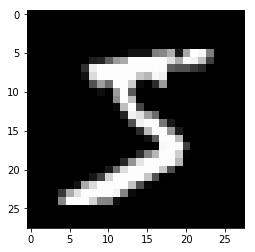

In [4]:
# Plotting example image
img = mnist.train.images[0]
img_resize = img.reshape((img_size, img_size))
plt.imshow(img_resize, cmap = 'gray')
plt.show()

In [5]:
# Initialize weights and bias 
# Convolution and pooling
def conv2d(x,w, stride):
	return tf.nn.conv2d(x,w,strides=[1, stride, stride, 1], padding='SAME')

# Get Variables
def weight_variable(name, shape):
    return tf.get_variable(name,shape=shape, initializer=tf.contrib.layers.xavier_initializer())

def bias_variable(name, shape):
    return tf.get_variable(name,shape=shape, initializer=tf.contrib.layers.xavier_initializer())

## Minimal RNN Function!!!

In [6]:
# Reset the graph
tf.reset_default_graph()

#Minimal RNN Variables
Wx = weight_variable('Wx', [flatten_size + rnn_size, rnn_size])
Uh = weight_variable('Uh', [rnn_size, rnn_size])
Uz = weight_variable('Uz', [rnn_size, rnn_size])

bz = bias_variable('bz', [rnn_size])
bu = bias_variable('bu', [rnn_size])

# Minimal RNN function
def MinimalRNN_cell(h_prev, x_rnn):
    # h_prev: output from cell of previous time step (shape: [batch_size, rnn_size])
    # x_rnn: input of rnn (shape: [batch_size, data_flatten_size])

    input_concat = tf.concat([x_rnn, h_prev], 1)
    z = tf.tanh(tf.matmul(input_concat, Wx) + bz)
    u = tf.sigmoid(tf.matmul(h_prev, Uh) + tf.matmul(z, Uz) + bu)
    
    h_t = tf.multiply(u, h_prev) + tf.multiply((1 - u), z)
    
    return h_t # Output

## RNN Network with Minimal RNN function

In [7]:
# Network

# Input 
x_image  = tf.placeholder(tf.float32, shape = [None, img_flat_size])
y_target = tf.placeholder(tf.float32, shape=[None, num_label])

input_flat = tf.reshape(x_image,[-1, step_size , flatten_size])
input_unstack = tf.unstack(input_flat, axis = 1)
################################### Minimal RNN ###################################
rnn_batch_size = tf.shape(input_flat)[0]
rnn_step_size = tf.shape(input_flat)[1]

rnn_out = tf.zeros([rnn_batch_size, rnn_size], tf.float32)

for i in range(len(input_unstack)):
    rnn_out = MinimalRNN_cell(rnn_out, input_unstack[i])
###################################################################################

rnn_out = tf.reshape(rnn_out ,shape = [-1, rnn_size])

# Densely connect layer variables 
w_fc1 = weight_variable('W_fc1', [rnn_size, 256])
b_fc1 = bias_variable('b_fc1', [256])

w_fc2 = weight_variable('W_fc2',[256, num_label])
b_fc2 = bias_variable('b_fc2',[num_label])

# Fully Connected Layer
h_fc1 = tf.nn.relu(tf.matmul(rnn_out, w_fc1)+b_fc1)
output = tf.matmul(h_fc1, w_fc2)+b_fc2

# Training 
Loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = y_target, logits = output)
Cost = tf.reduce_mean(Loss)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate, epsilon = epsilon).minimize(Cost)

correct_prediction = tf.equal(tf.argmax(y_target,1), tf.argmax(output,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Making Dataset

In [8]:
# Dataset for train, test, validation

test_len = mnist.test.images.shape[0]
validation_len = int(test_len * validation_ratio)

train_x = mnist.train.images
test_x = mnist.test.images[validation_len : test_len, :]
validation_x = mnist.test.images[ : validation_len, :]

train_y = mnist.train.labels
test_y = mnist.test.labels[validation_len : test_len]
validation_y = mnist.test.labels[ : validation_len]

print("Training set: " + str(train_x.shape))
print("Testing set: " + str(test_x.shape))
print("Validation set: " + str(validation_x.shape))

Training set: (60000, 784)
Testing set: (9000, 784)
Validation set: (1000, 784)


## Create Session

In [9]:
# Create Session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = gpu_fraction

sess = tf.InteractiveSession(config=config)
sess.run(tf.global_variables_initializer())

data = np.insert(train_x, img_flat_size, train_y, axis = 1)
len_data = data.shape[0]

## Training

In [10]:
# Training
for i in range(num_epoch):
    np.random.shuffle(data)

    data_x = data[:, :img_flat_size]
    data_y = data[:, img_flat_size]

    data_y_onehot = np.zeros([data_y.shape[0], num_label])
    for j in range(data_y.shape[0]):
        data_y_onehot[j, int(data_y[j])] = 1
    
    data_y_onehot_val = np.zeros([validation_y.shape[0], num_label])
    for j in range(validation_y.shape[0]):
        data_y_onehot_val[j, int(validation_y[j])] = 1
        
    batch_count = 1
    for j in range(0, len_data, batch_size):
        if j + batch_size < len_data:
            data_x_in = data_x[j : j + batch_size, :]
            data_y_in = data_y_onehot[j : j + batch_size, :]
        else:
            data_x_in = data_x[j : len_data, :]
            data_y_in = data_y_onehot[j : len_data, :]

        optimizer.run(feed_dict = {x_image: data_x_in, y_target: data_y_in})
        cost = sess.run(Cost, feed_dict = {x_image: data_x_in, y_target: data_y_in})
        acc = sess.run(accuracy, feed_dict = {x_image: data_x_in, y_target: data_y_in})
        val_acc = sess.run(accuracy, feed_dict = {x_image: validation_x, y_target: data_y_onehot_val})
        
        print("Epoch: " + str(i+1) + ' / ' + "Batch: " + str(j) + '/' + str(len_data) + ' / ' + "Cost: " + str(cost) + ' / ' + \
              "Training Accuracy: " + str(acc) + ' / ' + "Validation Accuracy: " + str(val_acc))

Epoch: 1 / Batch: 0/60000 / Cost: 0.6230108 / Training Accuracy: 0.0859375 / Validation Accuracy: 0.102
Epoch: 1 / Batch: 512/60000 / Cost: 0.47300416 / Training Accuracy: 0.095703125 / Validation Accuracy: 0.097
Epoch: 1 / Batch: 1024/60000 / Cost: 0.36926267 / Training Accuracy: 0.103515625 / Validation Accuracy: 0.106
Epoch: 1 / Batch: 1536/60000 / Cost: 0.3259597 / Training Accuracy: 0.119140625 / Validation Accuracy: 0.111
Epoch: 1 / Batch: 2048/60000 / Cost: 0.3288661 / Training Accuracy: 0.123046875 / Validation Accuracy: 0.144
Epoch: 1 / Batch: 2560/60000 / Cost: 0.33619583 / Training Accuracy: 0.107421875 / Validation Accuracy: 0.107
Epoch: 1 / Batch: 3072/60000 / Cost: 0.3392381 / Training Accuracy: 0.07421875 / Validation Accuracy: 0.074
Epoch: 1 / Batch: 3584/60000 / Cost: 0.33300933 / Training Accuracy: 0.08984375 / Validation Accuracy: 0.089
Epoch: 1 / Batch: 4096/60000 / Cost: 0.3281964 / Training Accuracy: 0.10546875 / Validation Accuracy: 0.099
Epoch: 1 / Batch: 4608/6

Epoch: 1 / Batch: 38912/60000 / Cost: 0.14401294 / Training Accuracy: 0.7265625 / Validation Accuracy: 0.667
Epoch: 1 / Batch: 39424/60000 / Cost: 0.14756611 / Training Accuracy: 0.6933594 / Validation Accuracy: 0.691
Epoch: 1 / Batch: 39936/60000 / Cost: 0.1513876 / Training Accuracy: 0.6894531 / Validation Accuracy: 0.663
Epoch: 1 / Batch: 40448/60000 / Cost: 0.140174 / Training Accuracy: 0.6953125 / Validation Accuracy: 0.686
Epoch: 1 / Batch: 40960/60000 / Cost: 0.14491208 / Training Accuracy: 0.7089844 / Validation Accuracy: 0.713
Epoch: 1 / Batch: 41472/60000 / Cost: 0.13105251 / Training Accuracy: 0.7753906 / Validation Accuracy: 0.726
Epoch: 1 / Batch: 41984/60000 / Cost: 0.13110752 / Training Accuracy: 0.7910156 / Validation Accuracy: 0.733
Epoch: 1 / Batch: 42496/60000 / Cost: 0.12616524 / Training Accuracy: 0.7558594 / Validation Accuracy: 0.71
Epoch: 1 / Batch: 43008/60000 / Cost: 0.12181427 / Training Accuracy: 0.7832031 / Validation Accuracy: 0.738
Epoch: 1 / Batch: 43520

Epoch: 2 / Batch: 18432/60000 / Cost: 0.035807617 / Training Accuracy: 0.9394531 / Validation Accuracy: 0.926
Epoch: 2 / Batch: 18944/60000 / Cost: 0.046443246 / Training Accuracy: 0.9316406 / Validation Accuracy: 0.93
Epoch: 2 / Batch: 19456/60000 / Cost: 0.041386724 / Training Accuracy: 0.9433594 / Validation Accuracy: 0.922
Epoch: 2 / Batch: 19968/60000 / Cost: 0.043985322 / Training Accuracy: 0.9238281 / Validation Accuracy: 0.918
Epoch: 2 / Batch: 20480/60000 / Cost: 0.038244717 / Training Accuracy: 0.9453125 / Validation Accuracy: 0.917
Epoch: 2 / Batch: 20992/60000 / Cost: 0.038356885 / Training Accuracy: 0.9453125 / Validation Accuracy: 0.925
Epoch: 2 / Batch: 21504/60000 / Cost: 0.048092086 / Training Accuracy: 0.9238281 / Validation Accuracy: 0.936
Epoch: 2 / Batch: 22016/60000 / Cost: 0.04601137 / Training Accuracy: 0.91796875 / Validation Accuracy: 0.93
Epoch: 2 / Batch: 22528/60000 / Cost: 0.036103867 / Training Accuracy: 0.9511719 / Validation Accuracy: 0.93
Epoch: 2 / Ba

Epoch: 2 / Batch: 57344/60000 / Cost: 0.024890961 / Training Accuracy: 0.9550781 / Validation Accuracy: 0.963
Epoch: 2 / Batch: 57856/60000 / Cost: 0.030579101 / Training Accuracy: 0.9433594 / Validation Accuracy: 0.966
Epoch: 2 / Batch: 58368/60000 / Cost: 0.019960623 / Training Accuracy: 0.97265625 / Validation Accuracy: 0.961
Epoch: 2 / Batch: 58880/60000 / Cost: 0.026742399 / Training Accuracy: 0.9609375 / Validation Accuracy: 0.951
Epoch: 2 / Batch: 59392/60000 / Cost: 0.020111699 / Training Accuracy: 0.9765625 / Validation Accuracy: 0.955
Epoch: 2 / Batch: 59904/60000 / Cost: 0.011762137 / Training Accuracy: 1.0 / Validation Accuracy: 0.959
Epoch: 3 / Batch: 0/60000 / Cost: 0.023629833 / Training Accuracy: 0.96484375 / Validation Accuracy: 0.955
Epoch: 3 / Batch: 512/60000 / Cost: 0.027832117 / Training Accuracy: 0.953125 / Validation Accuracy: 0.954
Epoch: 3 / Batch: 1024/60000 / Cost: 0.028509075 / Training Accuracy: 0.9589844 / Validation Accuracy: 0.956
Epoch: 3 / Batch: 1536

Epoch: 3 / Batch: 36864/60000 / Cost: 0.018782914 / Training Accuracy: 0.9746094 / Validation Accuracy: 0.967
Epoch: 3 / Batch: 37376/60000 / Cost: 0.021386942 / Training Accuracy: 0.95703125 / Validation Accuracy: 0.968
Epoch: 3 / Batch: 37888/60000 / Cost: 0.017062334 / Training Accuracy: 0.9707031 / Validation Accuracy: 0.966
Epoch: 3 / Batch: 38400/60000 / Cost: 0.024427861 / Training Accuracy: 0.9609375 / Validation Accuracy: 0.968
Epoch: 3 / Batch: 38912/60000 / Cost: 0.021170948 / Training Accuracy: 0.9550781 / Validation Accuracy: 0.973
Epoch: 3 / Batch: 39424/60000 / Cost: 0.014509139 / Training Accuracy: 0.9785156 / Validation Accuracy: 0.974
Epoch: 3 / Batch: 39936/60000 / Cost: 0.018193256 / Training Accuracy: 0.9667969 / Validation Accuracy: 0.969
Epoch: 3 / Batch: 40448/60000 / Cost: 0.016706169 / Training Accuracy: 0.9785156 / Validation Accuracy: 0.971
Epoch: 3 / Batch: 40960/60000 / Cost: 0.023154851 / Training Accuracy: 0.9589844 / Validation Accuracy: 0.972
Epoch: 3 

Epoch: 4 / Batch: 16384/60000 / Cost: 0.019086594 / Training Accuracy: 0.96875 / Validation Accuracy: 0.97
Epoch: 4 / Batch: 16896/60000 / Cost: 0.025751952 / Training Accuracy: 0.9589844 / Validation Accuracy: 0.971
Epoch: 4 / Batch: 17408/60000 / Cost: 0.019979551 / Training Accuracy: 0.96875 / Validation Accuracy: 0.971
Epoch: 4 / Batch: 17920/60000 / Cost: 0.016648453 / Training Accuracy: 0.98046875 / Validation Accuracy: 0.969
Epoch: 4 / Batch: 18432/60000 / Cost: 0.022621263 / Training Accuracy: 0.9609375 / Validation Accuracy: 0.972
Epoch: 4 / Batch: 18944/60000 / Cost: 0.0165221 / Training Accuracy: 0.9746094 / Validation Accuracy: 0.972
Epoch: 4 / Batch: 19456/60000 / Cost: 0.009776359 / Training Accuracy: 0.984375 / Validation Accuracy: 0.97
Epoch: 4 / Batch: 19968/60000 / Cost: 0.017005552 / Training Accuracy: 0.9765625 / Validation Accuracy: 0.971
Epoch: 4 / Batch: 20480/60000 / Cost: 0.013929889 / Training Accuracy: 0.9746094 / Validation Accuracy: 0.968
Epoch: 4 / Batch: 

Epoch: 4 / Batch: 55296/60000 / Cost: 0.014801416 / Training Accuracy: 0.9785156 / Validation Accuracy: 0.976
Epoch: 4 / Batch: 55808/60000 / Cost: 0.02053255 / Training Accuracy: 0.9765625 / Validation Accuracy: 0.976
Epoch: 4 / Batch: 56320/60000 / Cost: 0.009342164 / Training Accuracy: 0.98828125 / Validation Accuracy: 0.98
Epoch: 4 / Batch: 56832/60000 / Cost: 0.0134087205 / Training Accuracy: 0.9785156 / Validation Accuracy: 0.98
Epoch: 4 / Batch: 57344/60000 / Cost: 0.00912161 / Training Accuracy: 0.9824219 / Validation Accuracy: 0.981
Epoch: 4 / Batch: 57856/60000 / Cost: 0.008806126 / Training Accuracy: 0.98828125 / Validation Accuracy: 0.981
Epoch: 4 / Batch: 58368/60000 / Cost: 0.014933643 / Training Accuracy: 0.9765625 / Validation Accuracy: 0.981
Epoch: 4 / Batch: 58880/60000 / Cost: 0.010315435 / Training Accuracy: 0.9824219 / Validation Accuracy: 0.981
Epoch: 4 / Batch: 59392/60000 / Cost: 0.012849624 / Training Accuracy: 0.9765625 / Validation Accuracy: 0.981
Epoch: 4 / 

Epoch: 5 / Batch: 34816/60000 / Cost: 0.012967068 / Training Accuracy: 0.9765625 / Validation Accuracy: 0.981
Epoch: 5 / Batch: 35328/60000 / Cost: 0.0104824435 / Training Accuracy: 0.984375 / Validation Accuracy: 0.975
Epoch: 5 / Batch: 35840/60000 / Cost: 0.01189026 / Training Accuracy: 0.98046875 / Validation Accuracy: 0.974
Epoch: 5 / Batch: 36352/60000 / Cost: 0.011060024 / Training Accuracy: 0.98046875 / Validation Accuracy: 0.979
Epoch: 5 / Batch: 36864/60000 / Cost: 0.010524603 / Training Accuracy: 0.98046875 / Validation Accuracy: 0.979
Epoch: 5 / Batch: 37376/60000 / Cost: 0.007427326 / Training Accuracy: 0.9902344 / Validation Accuracy: 0.977
Epoch: 5 / Batch: 37888/60000 / Cost: 0.011007401 / Training Accuracy: 0.9824219 / Validation Accuracy: 0.981
Epoch: 5 / Batch: 38400/60000 / Cost: 0.01184996 / Training Accuracy: 0.9785156 / Validation Accuracy: 0.984
Epoch: 5 / Batch: 38912/60000 / Cost: 0.020272959 / Training Accuracy: 0.97265625 / Validation Accuracy: 0.983
Epoch: 5

Epoch: 6 / Batch: 14336/60000 / Cost: 0.011782908 / Training Accuracy: 0.98828125 / Validation Accuracy: 0.985
Epoch: 6 / Batch: 14848/60000 / Cost: 0.0072660684 / Training Accuracy: 0.9921875 / Validation Accuracy: 0.978
Epoch: 6 / Batch: 15360/60000 / Cost: 0.008019863 / Training Accuracy: 0.9863281 / Validation Accuracy: 0.978
Epoch: 6 / Batch: 15872/60000 / Cost: 0.012116981 / Training Accuracy: 0.9863281 / Validation Accuracy: 0.979
Epoch: 6 / Batch: 16384/60000 / Cost: 0.009359835 / Training Accuracy: 0.9863281 / Validation Accuracy: 0.98
Epoch: 6 / Batch: 16896/60000 / Cost: 0.008307763 / Training Accuracy: 0.98828125 / Validation Accuracy: 0.978
Epoch: 6 / Batch: 17408/60000 / Cost: 0.006799142 / Training Accuracy: 0.9921875 / Validation Accuracy: 0.983
Epoch: 6 / Batch: 17920/60000 / Cost: 0.01363371 / Training Accuracy: 0.9824219 / Validation Accuracy: 0.981
Epoch: 6 / Batch: 18432/60000 / Cost: 0.008305488 / Training Accuracy: 0.984375 / Validation Accuracy: 0.978
Epoch: 6 /

Epoch: 6 / Batch: 53248/60000 / Cost: 0.008525544 / Training Accuracy: 0.9863281 / Validation Accuracy: 0.984
Epoch: 6 / Batch: 53760/60000 / Cost: 0.0029989907 / Training Accuracy: 0.9980469 / Validation Accuracy: 0.981
Epoch: 6 / Batch: 54272/60000 / Cost: 0.005412572 / Training Accuracy: 0.99609375 / Validation Accuracy: 0.977
Epoch: 6 / Batch: 54784/60000 / Cost: 0.019256115 / Training Accuracy: 0.9746094 / Validation Accuracy: 0.979
Epoch: 6 / Batch: 55296/60000 / Cost: 0.009180787 / Training Accuracy: 0.984375 / Validation Accuracy: 0.98
Epoch: 6 / Batch: 55808/60000 / Cost: 0.014502982 / Training Accuracy: 0.9785156 / Validation Accuracy: 0.982
Epoch: 6 / Batch: 56320/60000 / Cost: 0.013263384 / Training Accuracy: 0.9824219 / Validation Accuracy: 0.981
Epoch: 6 / Batch: 56832/60000 / Cost: 0.008268548 / Training Accuracy: 0.98828125 / Validation Accuracy: 0.979
Epoch: 6 / Batch: 57344/60000 / Cost: 0.008814739 / Training Accuracy: 0.98828125 / Validation Accuracy: 0.978
Epoch: 6

Epoch: 7 / Batch: 32768/60000 / Cost: 0.0056278496 / Training Accuracy: 0.9902344 / Validation Accuracy: 0.981
Epoch: 7 / Batch: 33280/60000 / Cost: 0.004717634 / Training Accuracy: 0.9921875 / Validation Accuracy: 0.982
Epoch: 7 / Batch: 33792/60000 / Cost: 0.0047171838 / Training Accuracy: 0.9921875 / Validation Accuracy: 0.984
Epoch: 7 / Batch: 34304/60000 / Cost: 0.008391123 / Training Accuracy: 0.9863281 / Validation Accuracy: 0.985
Epoch: 7 / Batch: 34816/60000 / Cost: 0.0098445 / Training Accuracy: 0.984375 / Validation Accuracy: 0.984
Epoch: 7 / Batch: 35328/60000 / Cost: 0.01038664 / Training Accuracy: 0.984375 / Validation Accuracy: 0.984
Epoch: 7 / Batch: 35840/60000 / Cost: 0.009182776 / Training Accuracy: 0.984375 / Validation Accuracy: 0.983
Epoch: 7 / Batch: 36352/60000 / Cost: 0.010521107 / Training Accuracy: 0.9824219 / Validation Accuracy: 0.98
Epoch: 7 / Batch: 36864/60000 / Cost: 0.0049420367 / Training Accuracy: 0.9941406 / Validation Accuracy: 0.981
Epoch: 7 / Bat

Epoch: 8 / Batch: 12288/60000 / Cost: 0.005648046 / Training Accuracy: 0.9941406 / Validation Accuracy: 0.979
Epoch: 8 / Batch: 12800/60000 / Cost: 0.0046810536 / Training Accuracy: 0.9921875 / Validation Accuracy: 0.976
Epoch: 8 / Batch: 13312/60000 / Cost: 0.0073467605 / Training Accuracy: 0.984375 / Validation Accuracy: 0.972
Epoch: 8 / Batch: 13824/60000 / Cost: 0.008534854 / Training Accuracy: 0.98828125 / Validation Accuracy: 0.973
Epoch: 8 / Batch: 14336/60000 / Cost: 0.005134991 / Training Accuracy: 0.9902344 / Validation Accuracy: 0.974
Epoch: 8 / Batch: 14848/60000 / Cost: 0.0052741147 / Training Accuracy: 0.9921875 / Validation Accuracy: 0.978
Epoch: 8 / Batch: 15360/60000 / Cost: 0.005570943 / Training Accuracy: 0.9921875 / Validation Accuracy: 0.977
Epoch: 8 / Batch: 15872/60000 / Cost: 0.0063255234 / Training Accuracy: 0.9941406 / Validation Accuracy: 0.977
Epoch: 8 / Batch: 16384/60000 / Cost: 0.0073608086 / Training Accuracy: 0.9921875 / Validation Accuracy: 0.977
Epoch

Epoch: 8 / Batch: 51200/60000 / Cost: 0.006272219 / Training Accuracy: 0.9921875 / Validation Accuracy: 0.985
Epoch: 8 / Batch: 51712/60000 / Cost: 0.005022844 / Training Accuracy: 0.9921875 / Validation Accuracy: 0.987
Epoch: 8 / Batch: 52224/60000 / Cost: 0.0073580914 / Training Accuracy: 0.9921875 / Validation Accuracy: 0.985
Epoch: 8 / Batch: 52736/60000 / Cost: 0.003867599 / Training Accuracy: 0.9921875 / Validation Accuracy: 0.982
Epoch: 8 / Batch: 53248/60000 / Cost: 0.005821531 / Training Accuracy: 0.9902344 / Validation Accuracy: 0.981
Epoch: 8 / Batch: 53760/60000 / Cost: 0.0056145205 / Training Accuracy: 0.9921875 / Validation Accuracy: 0.981
Epoch: 8 / Batch: 54272/60000 / Cost: 0.0054580704 / Training Accuracy: 0.9921875 / Validation Accuracy: 0.982
Epoch: 8 / Batch: 54784/60000 / Cost: 0.0098454375 / Training Accuracy: 0.98046875 / Validation Accuracy: 0.982
Epoch: 8 / Batch: 55296/60000 / Cost: 0.0054066386 / Training Accuracy: 0.9921875 / Validation Accuracy: 0.986
Epoc

Epoch: 9 / Batch: 30720/60000 / Cost: 0.006650348 / Training Accuracy: 0.9902344 / Validation Accuracy: 0.986
Epoch: 9 / Batch: 31232/60000 / Cost: 0.004150569 / Training Accuracy: 0.99609375 / Validation Accuracy: 0.984
Epoch: 9 / Batch: 31744/60000 / Cost: 0.003375718 / Training Accuracy: 0.9980469 / Validation Accuracy: 0.983
Epoch: 9 / Batch: 32256/60000 / Cost: 0.007222005 / Training Accuracy: 0.9902344 / Validation Accuracy: 0.982
Epoch: 9 / Batch: 32768/60000 / Cost: 0.002676641 / Training Accuracy: 1.0 / Validation Accuracy: 0.98
Epoch: 9 / Batch: 33280/60000 / Cost: 0.003196566 / Training Accuracy: 0.99609375 / Validation Accuracy: 0.977
Epoch: 9 / Batch: 33792/60000 / Cost: 0.0039037862 / Training Accuracy: 0.99609375 / Validation Accuracy: 0.978
Epoch: 9 / Batch: 34304/60000 / Cost: 0.0058039627 / Training Accuracy: 0.98828125 / Validation Accuracy: 0.976
Epoch: 9 / Batch: 34816/60000 / Cost: 0.0039527053 / Training Accuracy: 0.9921875 / Validation Accuracy: 0.977
Epoch: 9 /

Epoch: 10 / Batch: 9216/60000 / Cost: 0.005114589 / Training Accuracy: 0.9902344 / Validation Accuracy: 0.984
Epoch: 10 / Batch: 9728/60000 / Cost: 0.0048741912 / Training Accuracy: 0.9902344 / Validation Accuracy: 0.985
Epoch: 10 / Batch: 10240/60000 / Cost: 0.0057132244 / Training Accuracy: 0.9941406 / Validation Accuracy: 0.984
Epoch: 10 / Batch: 10752/60000 / Cost: 0.005036689 / Training Accuracy: 0.9941406 / Validation Accuracy: 0.983
Epoch: 10 / Batch: 11264/60000 / Cost: 0.0050273556 / Training Accuracy: 0.9902344 / Validation Accuracy: 0.982
Epoch: 10 / Batch: 11776/60000 / Cost: 0.0031838468 / Training Accuracy: 0.9980469 / Validation Accuracy: 0.982
Epoch: 10 / Batch: 12288/60000 / Cost: 0.003982167 / Training Accuracy: 0.99609375 / Validation Accuracy: 0.983
Epoch: 10 / Batch: 12800/60000 / Cost: 0.008945626 / Training Accuracy: 0.984375 / Validation Accuracy: 0.984
Epoch: 10 / Batch: 13312/60000 / Cost: 0.002535679 / Training Accuracy: 0.9941406 / Validation Accuracy: 0.986

Epoch: 10 / Batch: 48128/60000 / Cost: 0.0042202054 / Training Accuracy: 0.9941406 / Validation Accuracy: 0.983
Epoch: 10 / Batch: 48640/60000 / Cost: 0.0075448425 / Training Accuracy: 0.9902344 / Validation Accuracy: 0.985
Epoch: 10 / Batch: 49152/60000 / Cost: 0.0023997617 / Training Accuracy: 0.9980469 / Validation Accuracy: 0.984
Epoch: 10 / Batch: 49664/60000 / Cost: 0.003920614 / Training Accuracy: 0.9921875 / Validation Accuracy: 0.982
Epoch: 10 / Batch: 50176/60000 / Cost: 0.0030401 / Training Accuracy: 0.9941406 / Validation Accuracy: 0.98
Epoch: 10 / Batch: 50688/60000 / Cost: 0.0034392201 / Training Accuracy: 0.99609375 / Validation Accuracy: 0.977
Epoch: 10 / Batch: 51200/60000 / Cost: 0.0027488514 / Training Accuracy: 0.99609375 / Validation Accuracy: 0.974
Epoch: 10 / Batch: 51712/60000 / Cost: 0.0055837533 / Training Accuracy: 0.9902344 / Validation Accuracy: 0.976
Epoch: 10 / Batch: 52224/60000 / Cost: 0.005673137 / Training Accuracy: 0.9921875 / Validation Accuracy: 0.

## Testing

In [11]:
# Testing

test_y_onehot = np.zeros([test_y.shape[0], num_label])
for i in range(test_y.shape[0]):
    test_y_onehot[i, int(test_y[i])] = 1

test_result = sess.run(output, feed_dict = {x_image: test_x, rnn_batch_size: test_x.shape[0], rnn_step_size: step_size})

count_correct = 0
for i in range(test_result.shape[0]):
    prediction_y = np.argmax(test_result[i,:])
    
    if prediction_y == test_y[i]:
        count_correct += 1

test_acc = count_correct / test_result.shape[0]

print("Test Accuracy: " + str(test_acc))

Test Accuracy: 0.9872222222222222
